In [27]:
import bluesquare_data_pipelines.access as blsq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [4]:
#hivdr = blsq.dhis_instance("dhis2_cd_hivdr_prod")

In [ ]:
#report = hivdr.get_reported_de()

In [4]:
full_data.head()

,monthly,quarterly,dataelementname,catcomboname,population,action,sub_population,province,fosa,value
0,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
1,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
2,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
3,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
4,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"5 et 9 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0


In [5]:
def impute_zero_dataelementname(df):

    """ This function is used to populate a pandas dfs with rows for each data element and zero imputed value
    where at least one value for fosa x period x data element exists in the data.

    :param df: This is a pandas df that has rows only for manually inputed data element.

    :return: out: This function returns a pandas df augmented with extra rows for every existing data element.
    """

    import pandas as pd

    out = []

    list_fosa = df.fosa.unique()

    for fosa in list_fosa:
        sub_df = df[df.fosa == fosa]
        # first, drop duplicates in month x data element, then create a contigency table month x dataelement
        sub_df_piv = sub_df.drop_duplicates(subset=["monthly","dataelementname"], keep='last').pivot(index="monthly", columns="dataelementname", values=["value"])
        # second, stacked the values to go back to a df format with one row per month and data element
        # we replace NAs by 0, as we think that if a report was filled out, the missing values are really zeros
        sub_df_piv_stacked = sub_df_piv.fillna(0).stack()
        sub_df_piv_stacked = pd.DataFrame(sub_df_piv_stacked)
        sub_df_piv_stacked = sub_df_piv_stacked.reset_index()
        # finally, we merged it back with the original data frame
        #sub_df_col = sub_df[["province","fosa","monthly","quarterly"]]
        new_df = sub_df.merge(sub_df_piv_stacked, how = 'outer')

        out.append(new_df)
    # return the transformed data frame
    df_augmented = pd.concat(out)
    return(df_augmented)

In [6]:
full_data_imp = impute_zero_dataelementname(full_data)

In [7]:
len(full_data)

421229

In [8]:
len(full_data_imp)

572240

In [9]:
full_data_imp.head()

,monthly,quarterly,dataelementname,catcomboname,population,action,sub_population,province,fosa,value
0,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
1,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"Moins d'un an, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
2,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0
3,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"1 et 4 ans, NC",pvvih,pdv,soutien,kongo central,hgr boma,0
4,201808.0,2018Q3,PNLS-ARV-PVVIH perdues de vue enregistrés-soutien,"5 et 9 ans, AC",pvvih,pdv,soutien,kongo central,hgr boma,0


In [17]:
len(full_data_imp.monthly.unique().tolist())

22

In [18]:
len(full_data_imp.province.unique().tolist())

19

In [16]:
len(full_data_imp.fosa.unique().tolist())

77

In [20]:
full_data_imp.groupby(['monthly']).describe()

                   monthly 
quarterly  count   201701.0    13221
                   201702.0    13589
                   201703.0    14911
                   201704.0    13329
                   201705.0    13140
                   201706.0    15222
                   201707.0    24691
                   201708.0    21450
                   201709.0    19153
                   201710.0    15629
                   201711.0    15653
                   201712.0    16163
                   201801.0    31753
                   201802.0    27885
                   201803.0    26776
                   201804.0    27723
                   201805.0    26094
                   201806.0    25964
                   201807.0    22639
                   201808.0    18009
                   201809.0    11851
           unique  201701.0        1
                   201702.0        1
                   201703.0        1
                   201704.0        1
                   201705.0        1
          

In [88]:
count_fosa = full_data_imp.groupby(['fosa']).count().unstack()

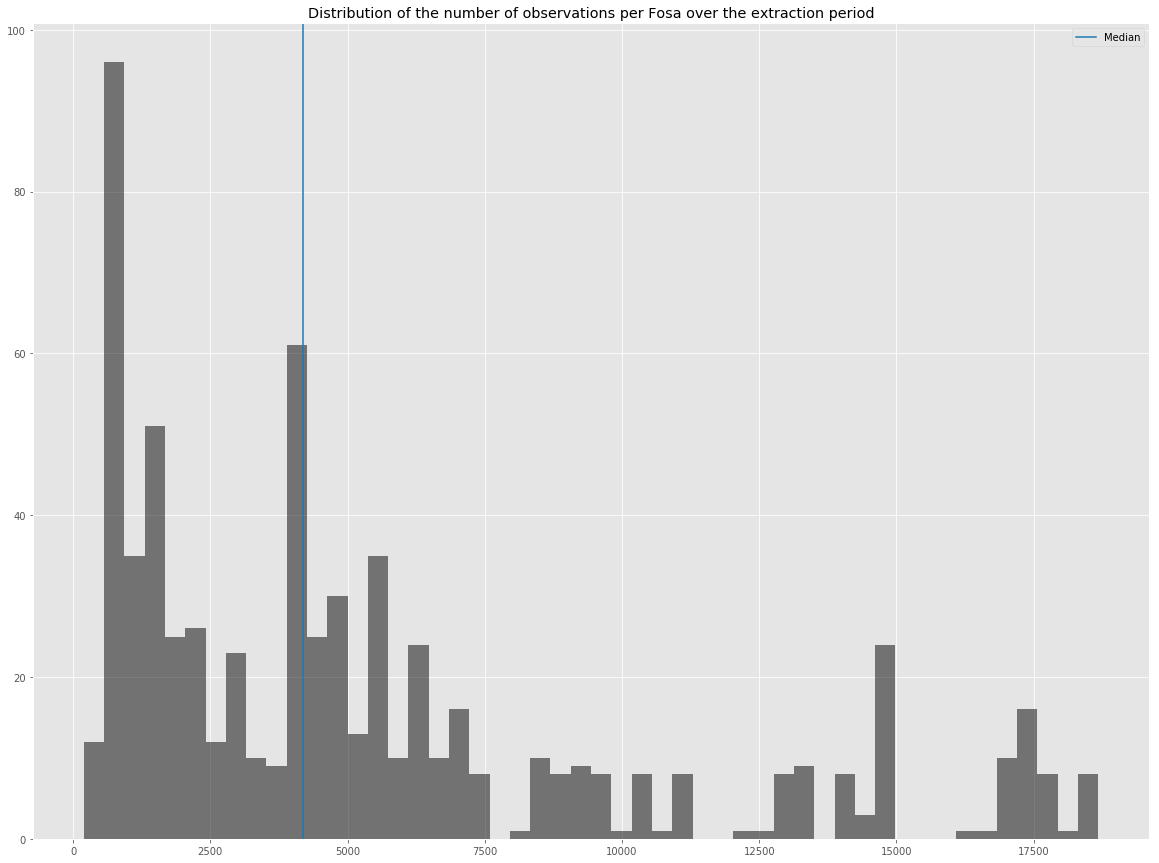

In [39]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(1,1,1)
    ax1.hist(count_fosa,bins=50,color='k',alpha=0.5)
    ax1.axvline(x=count_fosa.median(),label='Median')
    ax1.legend(loc='best')
    
    plt.title("Distribution of the number of observations per Fosa over the extraction period")

In [72]:
full_data_imp['year'] = full_data_imp["monthly"].astype(str).str[:4]#.unique().tolist()
full_data_imp['date'] = pd.to_datetime(full_data_imp["monthly"], format='%Y%m', errors='ignore')

In [58]:
count_fosa_year = full_data_imp.groupby(['fosa','year']).count().unstack()
count_fosa_year = count_fosa_year.dropna(axis=0, how='all')
count_fosa_year.head(n=20)

monthly              quarterly                \
year                  2017    2018  nan      2017    2018   nan   
fosa                                                              
 cs mopela          2550.0  1795.0  0.0    2550.0  1795.0  84.0   
 hgr dibindi        1023.0  1721.0  0.0    1023.0  1721.0  84.0   
camp kamalondo     10416.0  6801.0  0.0   10416.0  6801.0  84.0   
ch kikimi           2460.0  1540.0  0.0    2460.0  1540.0  84.0   
ch kitulizo            NaN  3023.0  0.0       NaN  3023.0  84.0   
ch rwankole            NaN  1445.0  0.0       NaN  1445.0  84.0   
ch saint francois    143.0  1350.0  0.0     143.0  1350.0  84.0   
ch sncc                NaN   621.0  0.0       NaN   621.0  84.0   
cs barriere            NaN  4145.0  0.0       NaN  4145.0  84.0   
cs bodeme.          2358.0  2197.0  0.0    2358.0  2197.0  84.0   
cs bomoi            4765.0  1559.0  0.0    4765.0  1559.0  84.0   
cs bomoto           5059.0  3346.0  0.0    5059.0  3346.0  84.0   
cs dream             452.0   649.0  0.0     452.0   649.0  84.0   
cs esengo           4703.0  1833.0  0.0    4703.0  1833.0  84.0   
cs manika           8362.0  8483.0  0.0    8362.0  8483.0  84.0   
cs mugunga           950.0  1313.0  0.0     950.0  1313.0  84.0   
cs muhungu             NaN   621.0  0.0       NaN   621.0  84.0   
cs murara           1219.0  1089.0  0.0    1219.0  1089.0  84.0   
cs neema           10307.0  3613.0  0.0   10307.0  3613.0  84.0   
cs radem               NaN   621.0  0.0       NaN   621.0  84.0   

                  dataelementname               catcomboname  ... action  \
year                         2017    2018   nan         2017  ...    nan   
fosa                                                          ...          
 cs mopela                 2550.0  1795.0  84.0       2550.0  ...   24.0   
 hgr dibindi               1023.0  1721.0  84.0       1023.0  ...   24.0   
camp kamalondo            10416.0  6801.0  84.0      10416.0  ...   24.0   
ch kikimi                  2460.0  1540.0  84.0       2460.0  ...   24.0   
ch kitulizo                   NaN  3023.0  84.0          NaN  ...   24.0   
ch rwankole                   NaN  1445.0  84.0          NaN  ...   24.0   
ch saint francois           143.0  1350.0  84.0        143.0  ...   24.0   
ch sncc                       NaN   621.0  84.0          NaN  ...   24.0   
cs barriere                   NaN  4145.0  84.0          NaN  ...   24.0   
cs bodeme.                 2358.0  2197.0  84.0       2358.0  ...   24.0   
cs bomoi                   4765.0  1559.0  84.0       4765.0  ...   24.0   
cs bomoto                  5059.0  3346.0  84.0       5059.0  ...   24.0   
cs dream                    452.0   649.0  84.0        452.0  ...   24.0   
cs esengo                  4703.0  1833.0  84.0       4703.0  ...   24.0   
cs manika                  8362.0  8483.0  84.0       8362.0  ...   24.0   
cs mugunga                  950.0  1313.0  84.0        950.0  ...   24.0   
cs muhungu                    NaN   621.0  84.0          NaN  ...   24.0   
cs murara                  1219.0  1089.0  84.0       1219.0  ...   24.0   
cs neema                  10307.0  3613.0  84.0      10307.0  ...   24.0   
cs radem                      NaN   621.0  84.0          NaN  ...   24.0   

                  sub_population               province                \
year                        2017    2018   nan     2017    2018   nan   
fosa                                                                    
 cs mopela                2550.0  1795.0  84.0   2550.0  1795.0  84.0   
 hgr dibindi              1023.0  1721.0  84.0   1023.0  1721.0  84.0   
camp kamalondo           10416.0  6801.0  84.0  10416.0  6801.0  84.0   
ch kikimi                 2460.0  1540.0  84.0   2460.0  1540.0  84.0   
ch kitulizo                  NaN  3023.0  84.0      NaN  3023.0  84.0   
ch rwankole                  NaN  1445.0  84.0      NaN  1445.0  84.0   
ch saint francois          143.0  1350.0  84.0    143.0  1350.0  84.0  

Text(0.5, 1.0, 'Scatterplot of the number of observations per Fosa in 2017 and 2018')

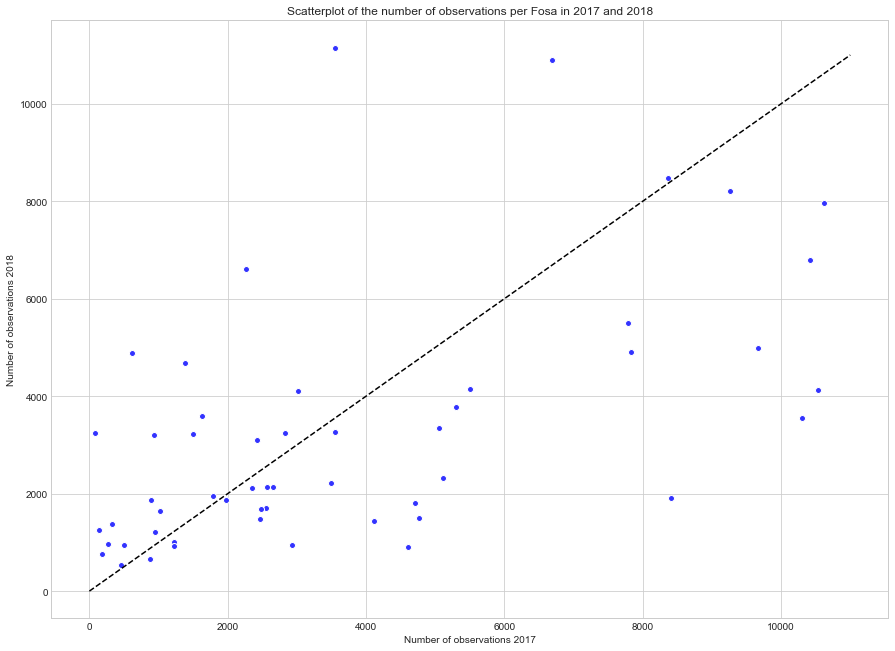

In [87]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(1,1,1)
ax.scatter(count_fosa_year['value']['2017'],count_fosa_year['value']['2018'], color="#3333FF", edgecolors='#FFFFFF')
plt.plot([0, 11000], [0, 11000], 'k-',linestyle='dashed')
plt.xlabel('Number of observations 2017')
plt.ylabel('Number of observations 2018')

plt.title("Scatterplot of the number of observations per Fosa in 2017 and 2018")

In [74]:
count_month = full_data_imp.groupby(['date']).count()
count_month.head()

,monthly,quarterly,dataelementname,catcomboname,population,action,sub_population,province,fosa,value,year
date,,,,,,,,,,,
2017-01-01,19652,13221,19652,13221,13221,13221,13221,13221,13221,19652,19652
2017-02-01,19923,13589,19923,13589,13589,13589,13589,13589,13589,19923,19923
2017-03-01,20930,14911,20930,14911,14911,14911,14911,14911,14911,20930,20930
2017-04-01,19296,13329,19296,13329,13329,13329,13329,13329,13329,19296,19296
2017-05-01,19744,13140,19744,13140,13140,13140,13140,13140,13140,19744,19744


Text(0.5, 1.0, 'Distribution of the number of observations per month over time')

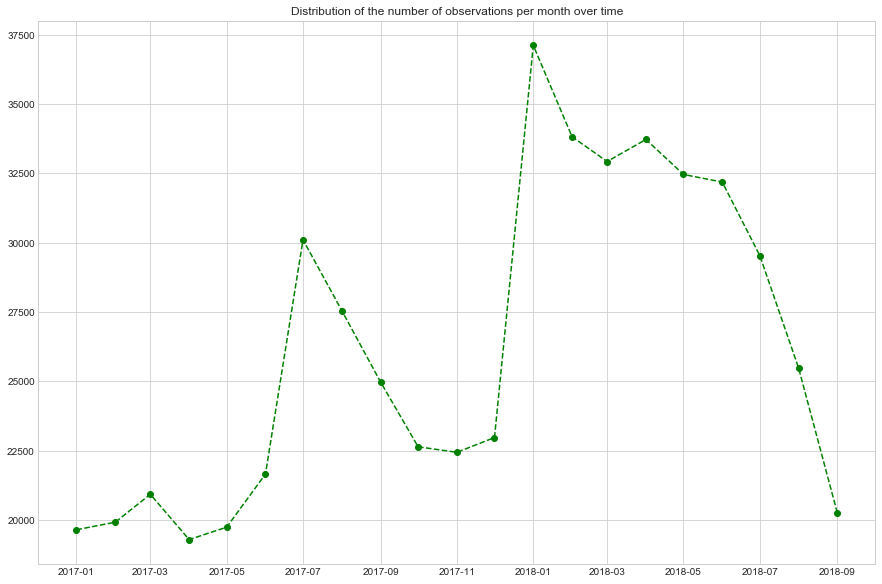

In [81]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.plot(count_month.value,color='g',marker='o',linestyle='dashed')
plt.title("Distribution of the number of observations per month over time")

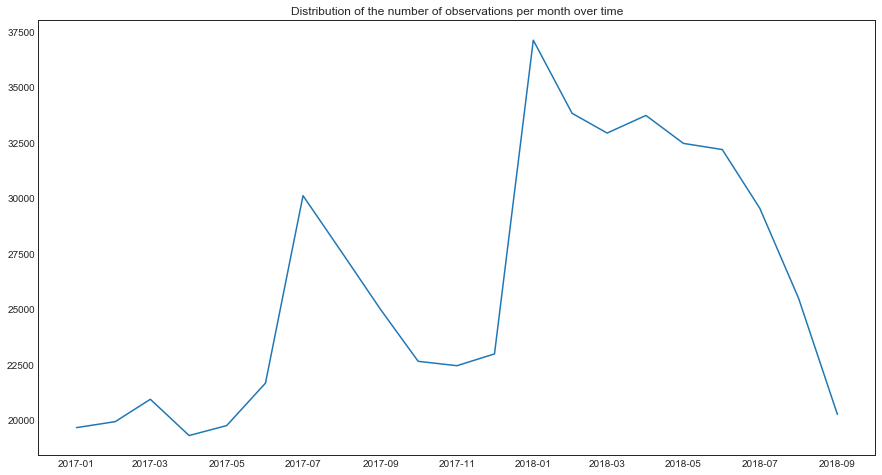

In [79]:
with sns.axes_style("ticks"):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,1,1)
    plt.plot(count_month.value)
    plt.title("Distribution of the number of observations per month over time")

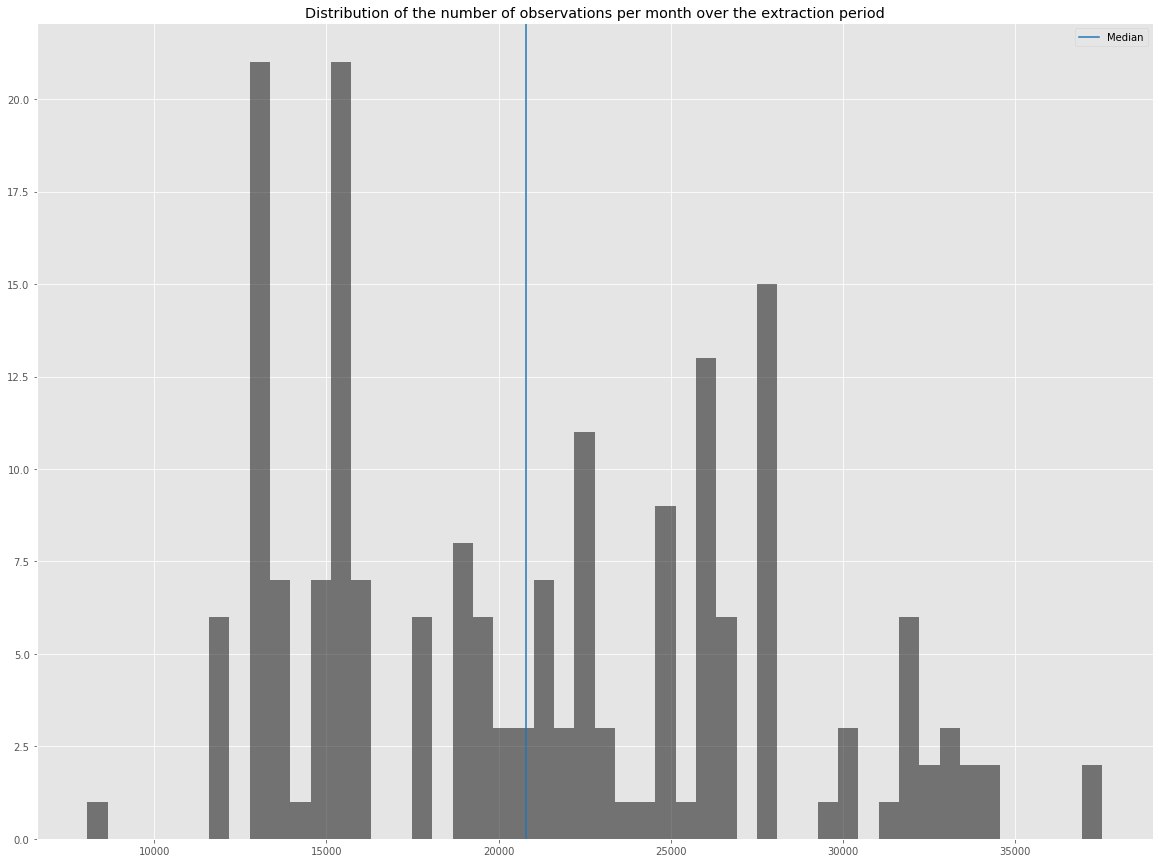

In [42]:
#with plt.style.context('ggplot'):
#    fig = plt.figure(figsize=(20,15))
#    ax1 = fig.add_subplot(1,1,1)
#    ax1.hist(count_month,bins=50,color='k',alpha=0.5)
#    ax1.axvline(x=count_month.median(),label='Median')
#    ax1.legend(loc='best')
    
#    plt.title("Distribution of the number of observations per month over the extraction period")